<a href="https://colab.research.google.com/github/Vedant2100/w26/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from datasets import load_dataset
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = load_dataset("ylecun/mnist")

def format_data(split):
    X, y = [], []
    mean = np.mean(split["image"])
    std = np.std(split["image"])
    for i in range(len(split)):
        img = np.array(split[i]["image"]).flatten()
        img = img - mean
        img = img / std
        img = np.append(img, 1)
        X.append(img)
        y_val = split[i]["label"]
        y_val = int(y_val > 4)
        y.append(y_val)
    return np.array(X), np.array(y)

Linear Classifier

In [ ]:
lambda_ = 0.01
X_train, y_train = format_data(dataset["train"])
X_test, y_test = format_data(dataset["test"])
def minibatch_sgd(ITR, B, lr, X_train, y_train, X_test, y_test):
    W = np.zeros((10, 785))
    loss_hist, acc_hist = [], []
    start = time.time()
    N_tr = len(X_train)
    for t in tqdm(range(ITR)):
        idx = np.random.choice(N_tr, B, replace=True)
        X_b, y_b = X_train[idx], y_train[idx]
        y_p = X_b @ W.T
        grad = (1/B) * (y_p - y_b).T @ X_b + lambda_ * W
        W -= lr * grad
        loss = 0.5 * np.mean(np.sum((y_p - y_b)**2, axis=1)) + (lambda_/2) * np.linalg.norm(W)**2
        loss_hist.append(loss)
        acc = np.mean(np.argmax(X_test @ W.T, axis=1) == np.argmax(y_test, axis=1))
        acc_hist.append(acc)
    return W, loss_hist, acc_hist, (time.time() - start)

In [ ]:
B = 10
lr = 0.005
ITR = 50000

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Different Batch Sizes")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Different Batch Sizes")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

loss_fig = plt.figure(1)
ax_loss = loss_fig.gca()
acc_fig = plt.figure(2)
ax_acc = acc_fig.gca()


_, losses, accs, dur = minibatch_sgd(ITR, B, lr, X_train, y_train, X_test, y_test)
print(f"B={B}: Time={dur:.2f}s, Accuracy={accs[-1]:.4f}")

ax_loss.plot(losses, label=f"B={B}")
ax_acc.plot(accs, label=f"B={B}")

ax_loss.legend()
ax_acc.legend()

loss_fig.show()
acc_fig.show()

S=100: Time=4.50s, Accuracy=0.6834
S=500: Time=4.91s, Accuracy=0.8221
S=1000: Time=5.33s, Accuracy=0.8234
S=10000: Time=4.53s, Accuracy=0.8530


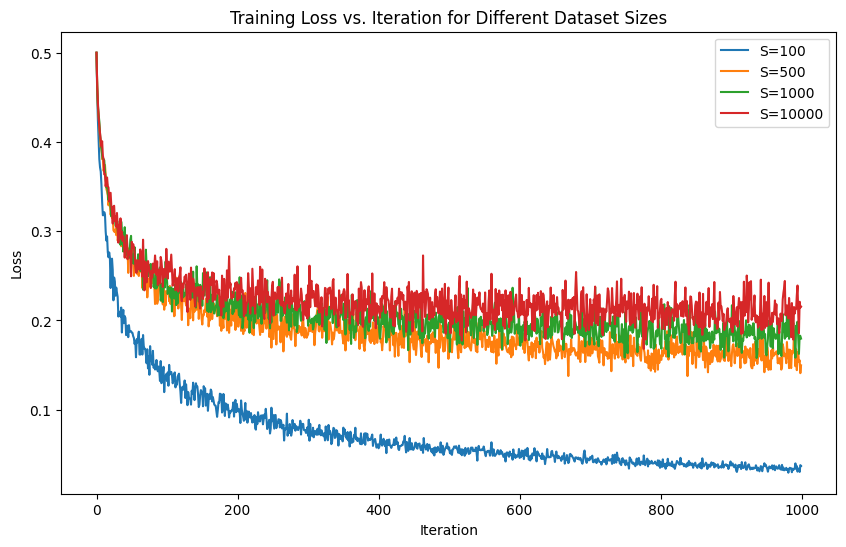

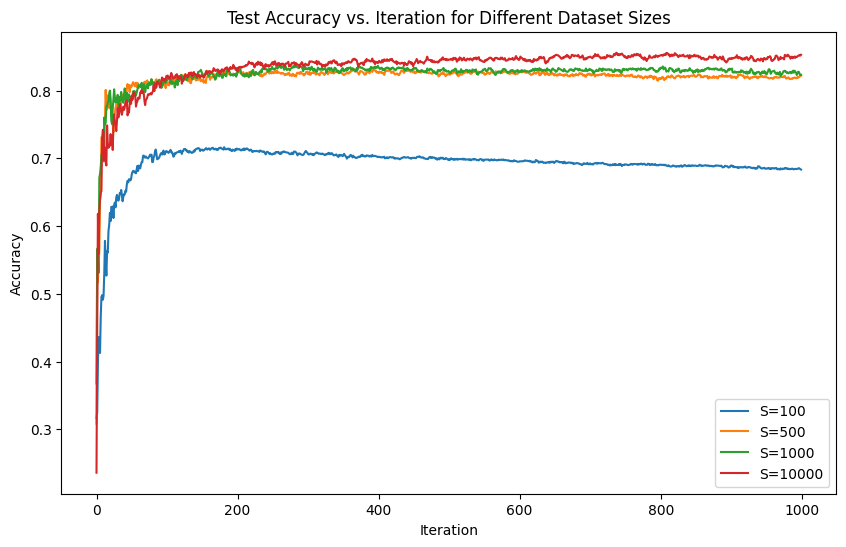

In [ ]:
S = [100, 500, 1000, 10000]
B, ITR, lr = 100, 1000, 0.01
X_train, y_train = format_data(dataset["train"])
X_test, y_test = format_data(dataset["test"])

plt.figure(figsize=(10, 6))
plt.title("Training Loss vs. Iteration for Different Dataset Sizes")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.figure(figsize=(10, 6))
plt.title("Test Accuracy vs. Iteration for Different Dataset Sizes")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

loss_fig = plt.figure(1)
ax_loss = loss_fig.gca()
acc_fig = plt.figure(2)
ax_acc = acc_fig.gca()

for s in S:
   idx = np.random.choice(len(X_train), s, replace=False)
   X_tr, y_tr = X_train[idx], y_train[idx]
   W, losses, accs, dur = minibatch_sgd(ITR, B, lr, X_tr, y_tr, X_test, y_test)
   print(f"S={s}: Time={dur:.2f}s, Accuracy={accs[-1]:.4f}")
   ax_loss.plot(losses, label=f"S={s}")
   ax_acc.plot(accs, label=f"S={s}")

ax_loss.legend()
ax_acc.legend()

loss_fig.show()
acc_fig.show()

PyTorch Accuracy: 0.8545


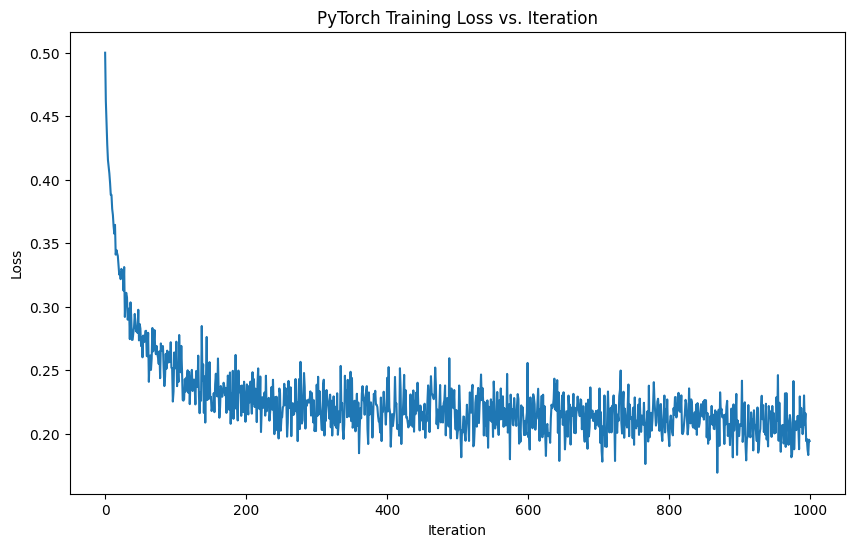

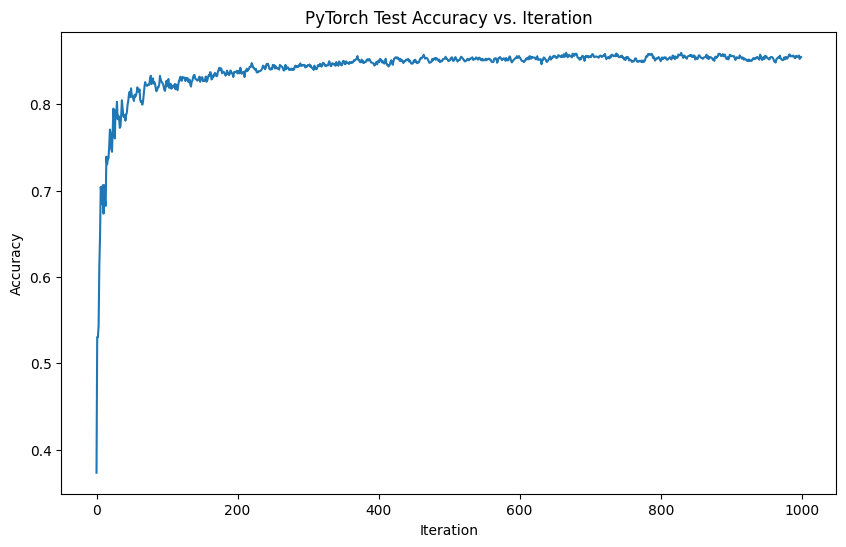

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

X_train, y_train = format_data(dataset["train"])
X_test, y_test = format_data(dataset["test"])
X_tr_t = torch.tensor(X_train, dtype=torch.float32)
y_tr_t = torch.tensor(y_train, dtype=torch.float32)
X_te_t = torch.tensor(X_test, dtype=torch.float32)
y_te_t = torch.tensor(y_test, dtype=torch.float32)
model = nn.Linear(784, 10, bias=False)
nn.init.zeros_(model.weight)
crit = nn.MSELoss(reduction="sum")
opt = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
loss_hist_pt = []
acc_hist_pt = []

for t in range(ITR):
    idx = np.random.choice(len(X_train), 100)
    opt.zero_grad()
    loss = (0.5/100) * crit(model(X_tr_t[idx]), y_tr_t[idx])
    loss.backward()
    opt.step()
    loss_hist_pt.append(loss.item())
    with torch.no_grad():
        preds = model(X_te_t)
        acc = (torch.argmax(preds, 1) == torch.argmax(y_te_t, 1)).float().mean()
        acc_hist_pt.append(acc.item())

print(f"PyTorch Accuracy: {acc_hist_pt[-1]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(loss_hist_pt)
plt.title("PyTorch Training Loss vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(acc_hist_pt)
plt.title("PyTorch Test Accuracy vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()